In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.scipy.special import erf

from scipy.optimize import curve_fit

## Building Fidelity Model for Sherbrooke

## Comparing with Experiment Results

In [2]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_28373/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

### KYOTO DETAILS ###
backend = provider.get_backend('ibm_sherbrooke')
qubit = 1

In [4]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 2
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7f87a06a0760>
backend_name
ibm_sherbrooke
backend_version
1.4.45
n_qubits
127
basis_gates
['id', 'rz', 'sx', 'x', 'ecr', 'reset']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112

## RR Dispersive Shift (Chi)

In [5]:
from exp_classes.device_charecterisation import RRFreqSpec

chi_exp = RRFreqSpec(
    qubit=qubit,
    backend=backend,
    freq_span=4.0 * MHz,
    num_experiments=81,
    fit_func_name='gaussian',
    chi_est=1. * MHz
)

In [6]:
chi_jobs, chi_info = chi_exp.get_jobs()

chi_info

{'Total Experiment Size': 162,
 'Frequency Step Size (MHz)': 0.05,
 'Frequency Span (MHz)': 4.0}

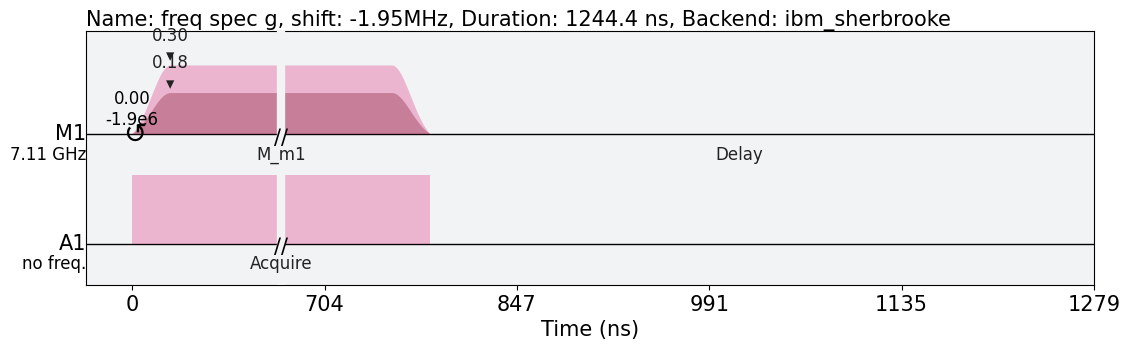

In [7]:
chi_jobs[1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## Standard Fidelity Experiment

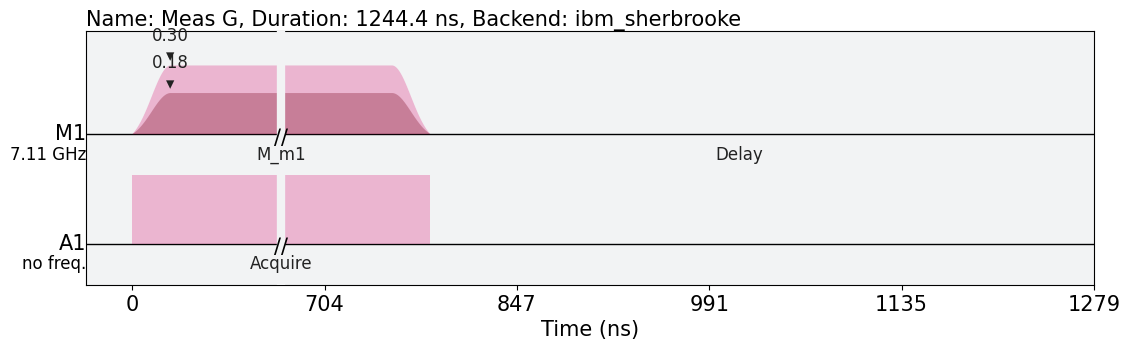

In [9]:
from exp_classes.device_charecterisation import StandardMeas

meas_exp = StandardMeas(qubit, backend)
meas_jobs = meas_exp.get_jobs()

meas_jobs[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## Acquisition Scan Experiment

In [10]:
from exp_classes.device_charecterisation import StandardAcqScanExp
from utils import get_dt_from

acq_latency_dt = get_dt_from(300 * ns, dt)

acq_exp = StandardAcqScanExp(
    qubit=qubit,
    backend=backend,
    acq_latency_dt=acq_latency_dt,
    acq_start_dt=get_dt_from(0. * ns, dt),
    acq_end_dt=measure_pulse.duration + measure_delay.duration + acq_latency_dt,
    num_acq_exp=141,
    acq_meas_dur_dt=get_dt_from(16. * ns, dt)
)

acq_jobs, acq_info = acq_exp.get_jobs()

acq_info

{'Total Experiment Size': 282,
 'Acquisition Latency (ns)': 299.0,
 'Acquisition Start Delay (ns)': 0.0,
 'Acquisition End Delay (ns)': 1543.0,
 'Acquisition Duration (ns)': 18.0}

In [11]:
print(acq_exp.acq_delay_linspace_ns/ns)

[   0.           11.02222222   22.04444444   33.06666667   44.08888889
   55.11111111   66.13333333   77.15555556   88.17777778   99.2
  110.22222222  121.24444444  132.26666667  143.28888889  154.31111111
  165.33333333  176.35555556  187.37777778  198.4         209.42222222
  220.44444444  231.46666667  242.48888889  253.51111111  264.53333333
  275.55555556  286.57777778  297.6         308.62222222  319.64444444
  330.66666667  341.68888889  352.71111111  363.73333333  374.75555556
  385.77777778  396.8         407.82222222  418.84444444  429.86666667
  440.88888889  451.91111111  462.93333333  473.95555556  484.97777778
  496.          507.02222222  518.04444444  529.06666667  540.08888889
  551.11111111  562.13333333  573.15555556  584.17777778  595.2
  606.22222222  617.24444444  628.26666667  639.28888889  650.31111111
  661.33333333  672.35555556  683.37777778  694.4         705.42222222
  716.44444444  727.46666667  738.48888889  749.51111111  760.53333333
  771.55555556  782.

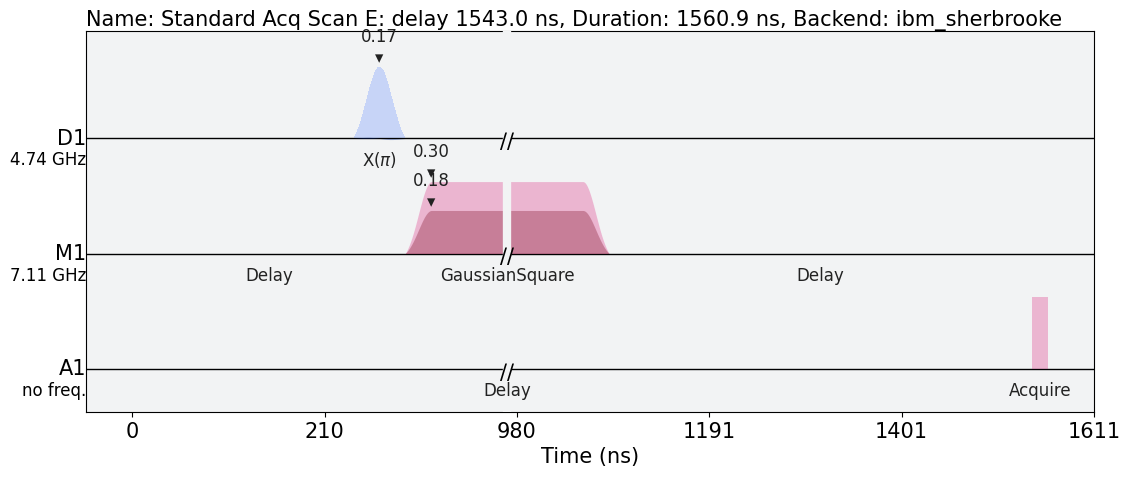

In [12]:
acq_jobs[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## Measuring Photon Population using AC Stark Shift

In [13]:
center_freq = -10.0 * MHz
freq_span = 40.0 * MHz
num_exps = 126
ac_freq_linspace = np.linspace(-0.5 * freq_span, 0.5 * freq_span, num_exps) + center_freq

reset_delay_dt = measure_delay.duration

print(ac_freq_linspace/MHz)

[-30.   -29.68 -29.36 -29.04 -28.72 -28.4  -28.08 -27.76 -27.44 -27.12
 -26.8  -26.48 -26.16 -25.84 -25.52 -25.2  -24.88 -24.56 -24.24 -23.92
 -23.6  -23.28 -22.96 -22.64 -22.32 -22.   -21.68 -21.36 -21.04 -20.72
 -20.4  -20.08 -19.76 -19.44 -19.12 -18.8  -18.48 -18.16 -17.84 -17.52
 -17.2  -16.88 -16.56 -16.24 -15.92 -15.6  -15.28 -14.96 -14.64 -14.32
 -14.   -13.68 -13.36 -13.04 -12.72 -12.4  -12.08 -11.76 -11.44 -11.12
 -10.8  -10.48 -10.16  -9.84  -9.52  -9.2   -8.88  -8.56  -8.24  -7.92
  -7.6   -7.28  -6.96  -6.64  -6.32  -6.    -5.68  -5.36  -5.04  -4.72
  -4.4   -4.08  -3.76  -3.44  -3.12  -2.8   -2.48  -2.16  -1.84  -1.52
  -1.2   -0.88  -0.56  -0.24   0.08   0.4    0.72   1.04   1.36   1.68
   2.     2.32   2.64   2.96   3.28   3.6    3.92   4.24   4.56   4.88
   5.2    5.52   5.84   6.16   6.48   6.8    7.12   7.44   7.76   8.08
   8.4    8.72   9.04   9.36   9.68  10.  ]


126


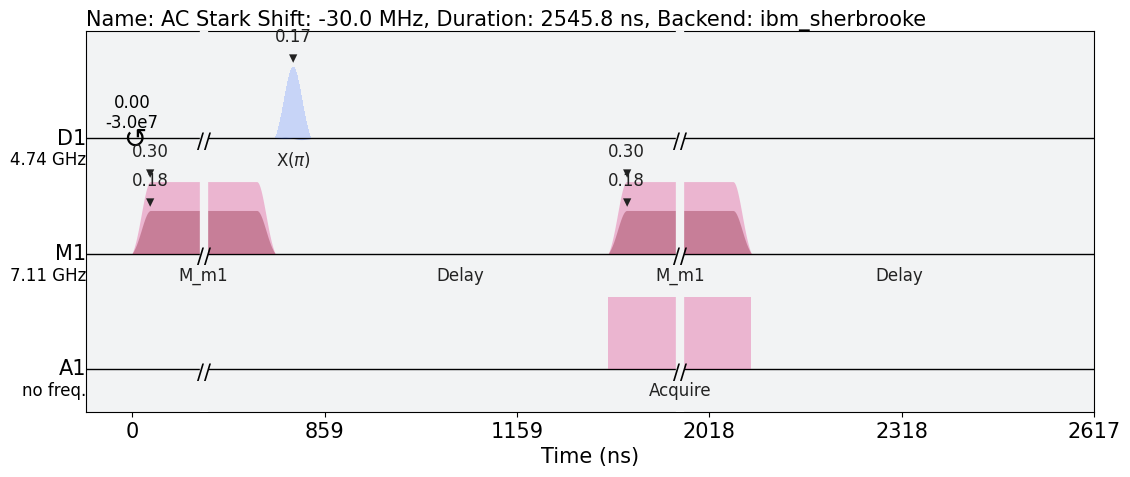

In [14]:
ac_freq_jobs = []

for freq_shift in ac_freq_linspace:
    with pulse.build(
        backend=backend,
        default_alignment='sequential',
        name=f'AC Stark Shift: {np.round(freq_shift/MHz, 1)} MHz'
    ) as ac_freq_sched:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)

        pulse.shift_frequency(freq_shift, qubit_chan)
        pulse.play(measure_pulse, meas_chan)
        pulse.play(x_pulse, qubit_chan)
        pulse.delay(reset_delay_dt, meas_chan)
        pulse.measure(qubit, pulse.MemorySlot(qubit))
    
    ac_freq_jobs.append(ac_freq_sched)

print(len(ac_freq_jobs))

ac_freq_jobs[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## Combining all Jobs and Running

In [15]:
from utils import acquisition_checker

normal_acq_job = chi_jobs + meas_jobs + ac_freq_jobs
low_acq_job = acq_jobs

num_shots = 8192
rep_delay = 499. * us

acquisition_checker(normal_acq_job, backend)
acquisition_checker(low_acq_job, backend)

print(len(normal_acq_job))
print(len(low_acq_job))

290
282


In [17]:
job_1 = provider.backend.retrieve_job(job_id='crwqmbhhazpg0084a61g')
# job 1 (normal_acq) needs to be run again with corrected ac stark shift exp
job_2 = provider.backend.retrieve_job(job_id='crwqf8xx484g008fdme0')

In [18]:
from utils import get_results_arr

results_1 = get_results_arr(job_1.result(), qubit)
results_2 = get_results_arr(job_2.result(), qubit)

In [19]:
len_chi_jobs = len(chi_jobs)
len_meas_jobs = len(meas_jobs)
len_ac_jobs = len(ac_freq_jobs)

chi_res = results_1[:len_chi_jobs]
meas_res = results_1[len_chi_jobs:len_chi_jobs + len_meas_jobs]
ac_stark_res = results_1[len_chi_jobs + len_meas_jobs:]

print(chi_res.shape)
print(meas_res.shape)
print(ac_stark_res.shape)

(162, 8192)
(2, 8192)
(126, 8192)


## Chi Results Analysis

Freq G: 0.12158414442584643 MHz
Freq E: -0.17330450487092408 MHz
Dispersive Shift: 0.2948886492967705 MHz
Kappa G: 0.17195299060556035 MHz
Kappa E: 0.1793966251476849 MHz
0.6870428373840194
0.7141934061558899
Dispersive Shift from Gauss: 0.30673334658839996


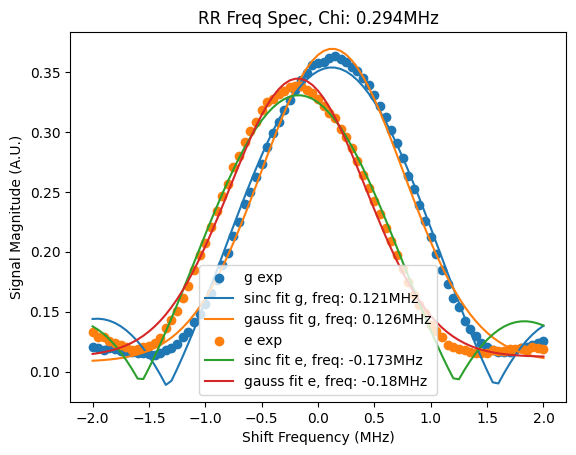

In [20]:
chi_abs_vals = np.mean(np.abs(chi_res), axis=-1)
chi_g, chi_e = chi_abs_vals.reshape(2, -1)

chi_freq_linspace = chi_exp.freq_linspace / MHz

def sinc_func(x, a, b, c, d):
    return np.abs(a * np.sinc(b * (x - c))) + d

def gaussian_func(x, a, c, b, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d

init_params_g = [50., 1., 0.5, 0.1]
init_params_e = [50., 1., -0.5, 0.1]

sinc_params_g, sinc_cov_g = curve_fit(sinc_func, chi_freq_linspace, chi_g, init_params_g)
sinc_params_e, sinc_cov_e = curve_fit(sinc_func, chi_freq_linspace, chi_e, init_params_e)

gauss_params_g, gauss_cov_g = curve_fit(gaussian_func, chi_freq_linspace, chi_g, init_params_g)
gauss_params_e, gauss_cov_e = curve_fit(gaussian_func, chi_freq_linspace, chi_e, init_params_e)

freq_g = sinc_params_g[2]
freq_e = sinc_params_e[2]

kappa_g = sinc_params_g[-1] * 2
kappa_e = sinc_params_e[-1] * 2

chi = freq_g - freq_e

freq_gauss_g = gauss_params_g[2]
freq_gauss_e = gauss_params_e[2]

kappa_gauss_g = gauss_params_g[-1] * 2
kappa_gauss_e = gauss_params_e[-1] * 2

gauss_chi = freq_gauss_g - freq_gauss_e

print(f"Freq G: {freq_g} MHz")
print(f"Freq E: {freq_e} MHz")
print(f"Dispersive Shift: {freq_g - freq_e} MHz")
print(f"Kappa G: {kappa_g} MHz")
print(f"Kappa E: {kappa_e} MHz")
print(sinc_params_g[1])
print(sinc_params_e[1])

print(f"Dispersive Shift from Gauss: {gauss_chi}")


plt.scatter(chi_freq_linspace, chi_g, label='g exp')
plt.plot(chi_freq_linspace, sinc_func(chi_freq_linspace, *sinc_params_g), label=f'sinc fit g, freq: {int(1e3*freq_g)/1e3}MHz')
plt.plot(chi_freq_linspace, gaussian_func(chi_freq_linspace, *gauss_params_g), label=f'gauss fit g, freq: {int(1e3*freq_gauss_g)/1e3}MHz')
plt.scatter(chi_freq_linspace, chi_e, label='e exp')
plt.plot(chi_freq_linspace, sinc_func(chi_freq_linspace, *sinc_params_e), label=f'sinc fit e, freq: {int(1e3*freq_e)/1e3}MHz')
plt.plot(chi_freq_linspace, gaussian_func(chi_freq_linspace, *gauss_params_e), label=f'gauss fit e, freq: {int(1e3*freq_gauss_e)/1e3}MHz')
plt.legend()
plt.xlabel('Shift Frequency (MHz)')
plt.ylabel('Signal Magnitude (A.U.)')
plt.title(f'RR Freq Spec, Chi: {int(1e3*chi)/1e3}MHz')
plt.show()

## Standard Fidelity Results

Fidelity: [0.98388672]
Separation Fidelity: [0.98846014]


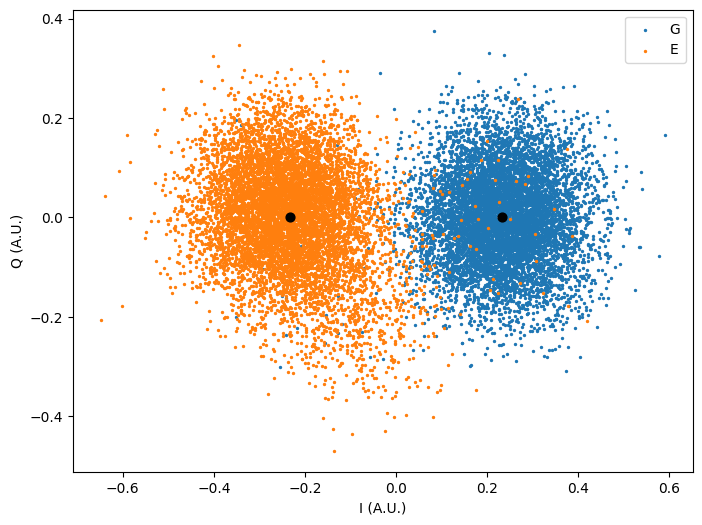

In [21]:
from utils import get_fidelity

meas_g, meas_e = meas_res.reshape(2, -1, num_shots)
fidelity, sep_fidelity = get_fidelity(meas_g, meas_e)

mean_g = np.mean(meas_g, axis=-1)
mean_e = np.mean(meas_e, axis=-1)

print(f"Fidelity: {fidelity}")
print(f"Separation Fidelity: {sep_fidelity}")

# Plot IQ Blobs
fig = plt.figure(figsize=(8.0, 6.0))

s = 2
s_mean = 40
c_mean = 'black'

plt.scatter(
    meas_g.real, 
    meas_g.imag, 
    label='G', 
    s=s
)
plt.scatter(
    meas_e.real, 
    meas_e.imag, 
    label='E', 
    s=s
)
plt.scatter(
    mean_g.real, 
    mean_g.imag, 
    # label='G', 
    s=s_mean,
    c=c_mean
)
plt.scatter(
    mean_e.real, 
    mean_e.imag, 
    # label='E', 
    s=s_mean,
    c=c_mean
)
plt.xlabel('I (A.U.)')
plt.ylabel('Q (A.U.)')
plt.legend()
plt.show()

## AC Stark Shift Results

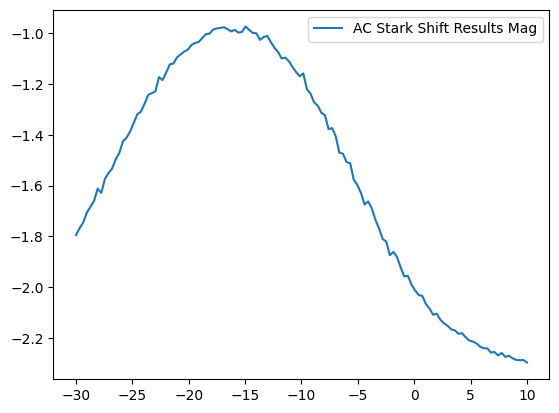

In [22]:
ac_mean_vals = np.mean(ac_stark_res, axis=-1)

ac_freq_linspace_MHz = ac_freq_linspace / MHz

# plt.plot(ac_freq_linspace_MHz, ac_mean_vals.real, label='AC Stark Shift Results R')
# plt.plot(ac_freq_linspace_MHz, ac_mean_vals.imag, label='AC Stark Shift Results I')
plt.plot(ac_freq_linspace_MHz, np.angle(ac_mean_vals), label='AC Stark Shift Results Mag')
plt.legend()
plt.show()

## Acquisition Scan Analysis

In [23]:
from utils import get_fidelity

acq_g, acq_e = results_2.reshape(2, -1, num_shots)
latency_fidelity, sep_latency_fidelity = get_fidelity(acq_g, acq_e)

0.99224853515625
1.2525244656278864


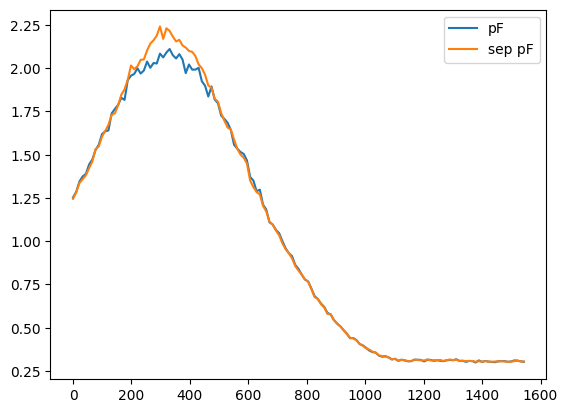

In [24]:
acq_linspace = acq_exp.acq_delay_linspace_ns / ns

print(np.max(latency_fidelity))

exp_pF = -np.log10(1. - latency_fidelity)
sep_pF = -np.log10(1. - sep_latency_fidelity)

print(exp_pF[0])

plt.plot(acq_linspace, exp_pF, label='pF')
plt.plot(acq_linspace, sep_pF, label='sep pF')
plt.legend()
plt.show()

## Simulation vs Experiment Comparison

In [29]:
ts_exp = acq_linspace

# All times in us and freqs in MHz
kappa = 10.07
chi = 0.92 * 2. * np.pi
N0 = 25.5

V = 0.4 # SNR Scaling Parameter

T1 = 286.0
gamma_n = 1/(1200.) # Photon Decay Rate
init_fid = 1.

t0 = 0.
t1 = 1.
num_ts = 361
ts = jnp.linspace(t0, t1, num_ts)
ts = ts_exp / 1000. + 0.400

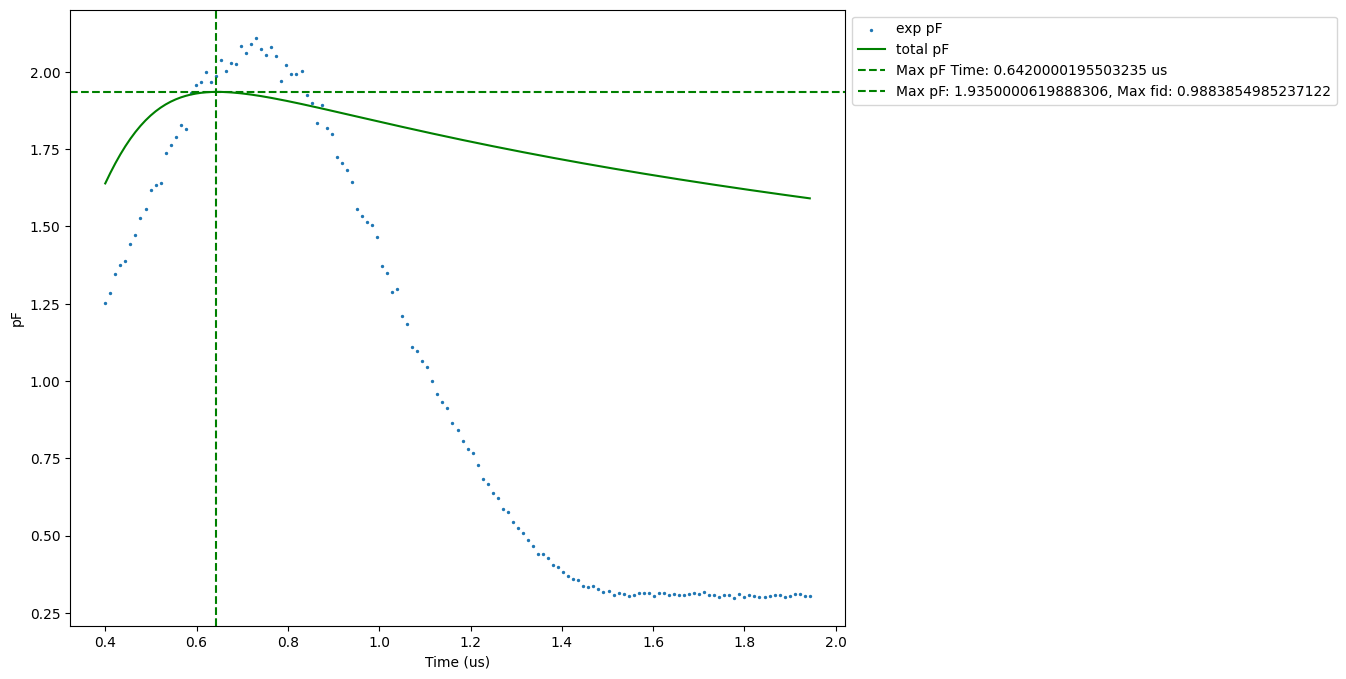

In [30]:
## Analytical Equations

separation = 2 * jnp.sqrt(N0 / (kappa**2  +chi**2)) * (chi * (1. - jnp.cos(0.5 * chi * ts) * jnp.exp(-0.5 * kappa * ts)) - kappa * jnp.sin(0.5 * chi * ts) * jnp.exp(-0.5 * kappa * ts))
fid_sep = 0.5 * (1. + erf(V * separation))
photons = N0 * (1. - 2. * jnp.cos(0.5 * chi * ts) * jnp.exp(-0.5 * kappa * ts) + jnp.exp(-kappa * ts))
gamma_down = 1 / T1 + gamma_n * photons
fid_qubit = 0.5 * (1. + jnp.exp(-gamma_down * ts))
fidelity = fid_sep * fid_qubit * init_fid

def pf(fid):
    return -jnp.log10(1. - fid)

def fid(pf):
    return 1 - 10**(-pf)

pf_sep = pf(fid_sep)
pf_qubit = pf(fid_qubit)
pf_total = pf(fidelity)

t_max_fidelity = jnp.round(ts[jnp.argmax(fidelity)], 3)
max_pF = jnp.round(jnp.max(pf_total), 3)
max_fidelity = fid(max_pF)

fig = plt.figure(figsize=(10.0, 8.0))

# plt.plot(ts, pf_sep, label='separation pF')
# plt.plot(ts, pf_qubit, label='qubit pF')
plt.scatter(ts, exp_pF, label='exp pF', s=2)
plt.plot(ts, pf_total, label='total pF', color='green')
plt.axvline(x=t_max_fidelity, label=f'Max pF Time: {t_max_fidelity} us', linestyle='dashed', color='green')
plt.axhline(y=max_pF, label=f'Max pF: {max_pF}, Max fid: {max_fidelity}', linestyle='dashed', color='green')
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.ylim(bottom=None, top=None)
plt.legend(bbox_to_anchor=(1., 1.))
plt.show()